### Implementation of cellpose for CAMPARI data

This notebook will read a set of .czi files (saved in green and red fluorecence).
It will convert .czi into a readable file format for cellpose.
We will run cellpose on Red fluorecence image, and plot the extracted template into the red and green flourecence image as a control. 
Later will extract cell size and intensity from green and red fluorecence for further processing.

In [1]:
import numpy as np
import time, os, sys
from urllib.parse import urlparse
import matplotlib.pyplot as plt
import matplotlib as mpl
from cellpose import utils, io
import czifile as czifile
import pandas as pd
import logging
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    # Warning-causing lines of code here
from PIL import Image

In [ ]:
### Define all relevant directories and paths
directory_path = '/home/melma31/Documents/campari/'

### Input data base with mice data
data_base_path = directory_path + 'data_base.xlsx'

### Output data base with cell data. Backup copy is done simultaneusly (this is in case the code breaks while saving data base)
data_base_path_output = directory_path + 'data_base_output.xlsx'
data_base_path_output_bkup = directory_path + 'data_base_output_bkup.xlsx'

In [ ]:
### If only some animals, days, side what to be analyzed, select them in here
MOUSE = None
SIDE = None
EXAMPLE = None
DATE = None


### Parameters for CELLPOSE AND FOR POSTERIOR SELECTION
DIAMETER = 20
### MODEL SELECTION : add posibilities between model_type='cyto' or model_type='nuclei'
MODEL = 'cyto2'
CHANNELS = [0,0]
CELLSIZE = 250

In [2]:


mouse_data = pd.read_excel(data_base_path)
cell_data_output = pd.read_excel(data_base_path_output)
print(mouse_data)
#print(cell_data_output)
#mouse_number = 1 
#mouse_data = dbase.loc[dbase['mouse_id'] == mouse_number]

     date  month  year  mouse_id  condition  stimuli  side  example  \
0      11      1  2023         1          1        1     0        1   
1      11      1  2023         1          1        1     0        2   
2      11      1  2023         1          1        1     0        3   
3      11      1  2023         1          1        1     0        4   
4      11      1  2023         1          1        1     0        5   
..    ...    ...   ...       ...        ...      ...   ...      ...   
96     25      1  2023         2          1        2     0        6   
97     25      1  2023         2          1        2     1        1   
98     25      1  2023         2          1        2     1        2   
99     25      1  2023         2          1        2     1        3   
100    25      1  2023         2          1        2     1        4   

    green_file_name red_file_name  
0             GREEN           RED  
1             GREEN           RED  
2             GREEN           RED  
3  

In [3]:
### PART 2: SELECT DESIRED DATA TO ANALYSE
# Select only red channel data
#selected_data = mouse_data.loc[mouse_data['date'] == DATE]
#selected_data = selected_data.loc[selected_data['mouse_id'] == MOUSE]
#selected_data = selected_data.loc[selected_data['example'] == EXAMPLE]
#selected_data = selected_data.loc[selected_data['side'] == SIDE]

selected_data = mouse_data
mouse_data = selected_data

In [15]:
## PART 1: CONVERT ALL FILES
# load all files in the data base and convert czi to tif
for i in range(len(mouse_data)):
    date = mouse_data.iloc[i].date
    month =  mouse_data.iloc[i].month
    year =  mouse_data.iloc[i].year
    mouse = mouse_data.iloc[i].mouse_id
    folder_structure = str(date) + '.' + str(month) + '.'+ str(year) + '/animal_' + str(mouse)
    side = mouse_data.iloc[i].side
    if side == 0:
        folder_structure = folder_structure + '/left/'
    else:
        folder_structure = folder_structure + '/right/'
    example = mouse_data.iloc[i].example
    file_path = directory_path +'data/' + folder_structure + str(example) + '_' + mouse_data.iloc[i].green_file_name
    images = czifile.imread(file_path + '.czi')
    images = images[0,:,:,0]
    im = Image.fromarray(images)
    im.save(file_path+'.tif')
    
    file_path = directory_path +'data/' + folder_structure + str(example) + '_' + mouse_data.iloc[i].red_file_name
    images = czifile.imread(file_path + '.czi')
    images = images[0,:,:,0]
    im = Image.fromarray(images)
    im.save(file_path+'.tif')
print('All files had been converted from .czi to .tif')

All files had been converted from .czi to .tif


In [16]:
print('Number of red channel data: ' + str(len(selected_data)))
# check that all tif files exists

# RUN CELLPOSE
from cellpose import models, io

# DEFINE CELLPOSE MODEL
# model_type='cyto' or model_type='nuclei'
model = models.Cellpose(gpu=False, model_type=MODEL)
channels = CHANNELS
diameter = DIAMETER
# define CHANNELS to run segementation on
# grayscale=0, R=1, G=2, B=3
# channels = [cytoplasm, nucleus]
# if NUCLEUS channel does not exist, set the second channel to 0
# channels = [0,0]
# IF ALL YOUR IMAGES ARE THE SAME TYPE, you can give a list with 2 elements
# channels = [0,0] # IF YOU HAVE GRAYSCALE
# channels = [2,3] # IF YOU HAVE G=cytoplasm and B=nucleus
# channels = [2,1] # IF YOU HAVE G=cytoplasm and R=nucleus

# or if you have different types of channels in each image
#channels = [[0,0], [0,0], [0,0]]

# if diameter is set to None, the size of the cells is estimated on a per image basis
# you can set the average cell `diameter` in pixels yourself (recommended) 
# diameter can be a list or a single number for all images

# you can run all in a list e.g.
# >>> imgs = [io.imread(filename) in for filename in files]
# >>> masks, flows, styles, diams = model.eval(imgs, diameter=None, channels=channels)
# >>> io.masks_flows_to_seg(imgs, masks, flows, diams, files, channels)
# >>> io.save_to_png(imgs, masks, flows, files)

# or in a loop
for i in range(len(selected_data)):
    date = selected_data.iloc[i].date
    month =  selected_data.iloc[i].month
    year =  selected_data.iloc[i].year
    mouse = selected_data.iloc[i].mouse_id
    folder_structure = str(date) + '.' + str(month) + '.'+ str(year) + '/animal_' + str(mouse)
    side = selected_data.iloc[i].side
    if side == 0:
        folder_structure = folder_structure + '/left/'
    else:
        folder_structure = folder_structure + '/right/'
    example = selected_data.iloc[i].example
    file_path = directory_path +'data/' + folder_structure + str(example) + '_' + selected_data.iloc[i].red_file_name
    filesname_red = file_path + '.tif'
    file_path = directory_path +'data/' + folder_structure + str(example) + '_' + selected_data.iloc[i].green_file_name
    filesname_green = file_path + '.tif'
    if not os.path.exists(filesname_red) or not os.path.exists(filesname_green):
        print(file_name + 'does not exist')
    else:
        print(filename)
        img = io.imread(filename_red + '.tif')
        masks, flows, styles, diams = model.eval(img, diameter=diameter, channels=channels)
        # save results so you can load in gui
        #io.masks_flows_to_seg(img, masks, flows, diams, filename, channels)
        # save results as png
        #flows_list.append(flows)
        io.save_to_png(img, masks, flows, filename)

Number of red channel data: 101


In [ ]:
# DISPLAY RESULTS

### THIS WILL PLOT FOR ALL SELECTED DATA orginal image and masks on top for red and green
### with red colors the ones rejected by CELLSIZE limit and in BLUE the accepted ones
from cellpose import plot
from cellpose import utils, io, transforms
from cellpose.plot import image_to_rgb, mask_overlay

# or in a loop
chan = CHANNELS
channels = CHANNELS
for i in range(len(selected_data)):
    date = selected_data.iloc[i].date
    month =  selected_data.iloc[i].month
    year =  selected_data.iloc[i].year
    mouse = selected_data.iloc[i].mouse_id
    folder_structure = str(date) + '.' + str(month) + '.'+ str(year) + '/animal_' + str(mouse)
    side = selected_data.iloc[i].side
    if side == 0:
        folder_structure = folder_structure + '/left/'
        figure_name = str(date) + '.' + str(month) + '.'+ str(year) + '_animal_' + str(mouse) + '_left_'
    else:
        folder_structure = folder_structure + '/right/'
        figure_name = str(date) + '.' + str(month) + '.'+ str(year) + '_animal_' + str(mouse) + '_right_'

    example = selected_data.iloc[i].example
    figure_name = figure_name + '_example_' + str(selected_data.iloc[i].example)
    file_path = directory_path +'data/' + folder_structure + str(example) + '_' + selected_data.iloc[i].red_file_name
    filesname = file_path 
    file_path = directory_path +'data/' + folder_structure + str(example) + '_' + selected_data.iloc[i].green_file_name
    filesname_2 = file_path
    mask_name = filesname + '_cp_masks.png'
    print(mask_name)
    if not os.path.exists(filesname + '.tif') or not os.path.exists(filesname_2 + '.tif') or not os.path.exists(mask_name):
        print('FILE does NOT exist')
    else:
        img = io.imread(filesname + '.tif')
        masks = io.imread(mask_name)
        img2 = io.imread(filesname_2 + '.tif')
        ncells = np.max(masks)
        print(ncells)
        fig, axes = plt.subplots(2,2)
        img0 = img.copy()
        if img0.shape[0] < 4:
            img0 = np.transpose(img0, (1,2,0))
        if img0.shape[-1] < 3 or img0.ndim < 3:
            img0 = image_to_rgb(img0, channels=channels)
        else:
            if img0.max()<=50.0:
                img0 = np.uint8(np.clip(img0*255, 0, 1))

        axes[0,0].imshow(img0)
        axes[0,0].set_title('RED CHANNEL')
        axes[0,0].axis('off')
        mask_copy = np.zeros_like(masks)
        for cell_num in range(1,ncells):
            cell_mask = np.where(masks == cell_num)
            cellsize = len(cell_mask[0])
            if cellsize >= 250:
                mask_copy[np.where(masks == cell_num)] = cell_num
        #        print(cell_num)
        #print(np.max(mask_copy))
        
        outlines = utils.masks_to_outlines(masks)
        #overlay = mask_overlay(img0, masks)
        outX, outY = np.nonzero(outlines)
        imgout= img0.copy()
        imgout[outX, outY] = np.array([255,0,0]) # pure red
        outlines = utils.masks_to_outlines(mask_copy)
        #overlay = mask_overlay(img0, masks)
        outX, outY = np.nonzero(outlines)
        imgout[outX, outY] = np.array([0,0,255]) # pure blue
        
        axes[0,1].imshow(imgout)
        axes[0,1].set_title('PREDITION')
        axes[0,1].axis('off')

        #axes[0,1].imshow(imgout)
        #axes[0,1].set_title('PREDITION')
        #axes[0,1].axis('off')

        img0 = img2.copy()
        if img0.shape[0] < 4:
            img0 = np.transpose(img0, (1,2,0))
        if img0.shape[-1] < 3 or img0.ndim < 3:
            img0 = image_to_rgb(img0, channels=channels)
        else:
            if img0.max()<=50.0:
                img0 = np.uint8(np.clip(img0*255, 0, 1))

        
        axes[1,0].imshow(img0)
        axes[1,0].set_title('GREEN CHANNEL')
        axes[1,0].axis('off')

        outlines = utils.masks_to_outlines(masks)
        #overlay = mask_overlay(img0, masks)
        outX, outY = np.nonzero(outlines)
        imgout= img0.copy()
        imgout[outX, outY] = np.array([255,0,0]) # pure red
        outlines = utils.masks_to_outlines(mask_copy)
        #overlay = mask_overlay(img0, masks)
        outX, outY = np.nonzero(outlines)
        imgout[outX, outY] = np.array([0,0,255]) # pure blue        
        
        axes[1,1].imshow(imgout)
        axes[1,1].set_title('PREDITION')
        axes[1,1].axis('off')

        plt.tight_layout()
        fig.savefig(directory_path + 'figures/'+ figure_name + '_ncells_' + str(ncells) + '.png')


In [20]:
cell_counter

206044

Exception ignored in: <function ZipFile.__del__ at 0x7fe9709cc280>
Traceback (most recent call last):
  File "/home/melma31/mambaforge/envs/cellpose/lib/python3.8/zipfile.py", line 1821, in __del__
    self.close()
  File "/home/melma31/mambaforge/envs/cellpose/lib/python3.8/zipfile.py", line 1838, in close
    self.fp.seek(self.start_dir)
ValueError: seek of closed file


2023


In [17]:
stimuli_color = ['k','orange','cyan','magenta','yellow']
stimuli_names = ['Mock','Stroke','Brush']

[0 1]


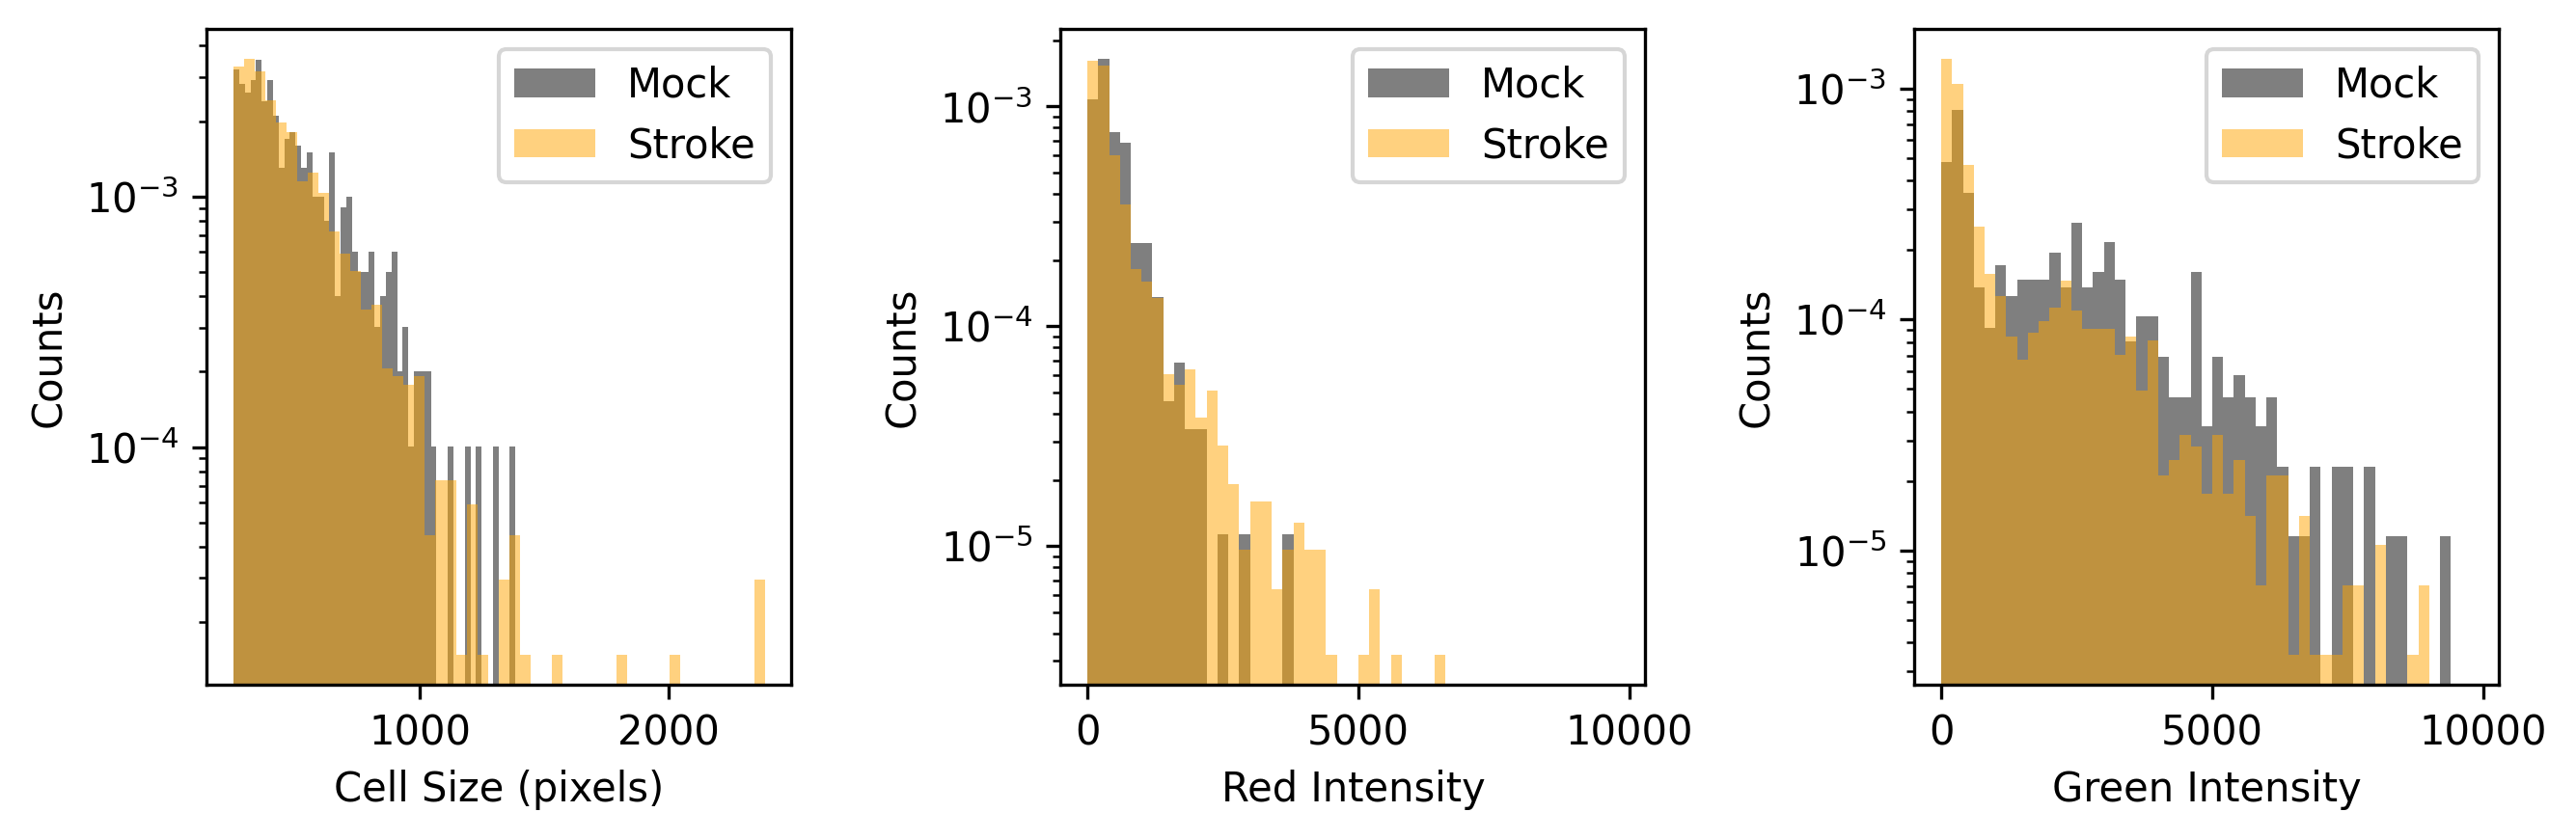

In [18]:

cell_data_output = pd.read_excel(data_base_path_output)
conditions = np.unique(cell_data_output['stimuli'])
print(conditions)

figure, axes = plt.subplots(1,3)

axes[0].set_xlabel('Cell Size (pixels)')
axes[0].set_ylabel('Counts')
axes[0].legend(['Convertion','Mock'])

bins = np.arange(0,10000,200)
axes[1].set_xlabel('Red Intensity')
axes[1].set_ylabel('Counts')
axes[1].legend(['Convertion1','Mock'])

axes[2].set_xlabel('Green Intensity')
axes[2].set_ylabel('Counts')
axes[2].legend(['Convertion','Mock'])


for con in conditions:

    selected_data = cell_data_output.loc[cell_data_output['stimuli']==con]
    cellsize = selected_data['cell_size']
    red_intensity = selected_data['red_int']
    green_intensity = selected_data['green_int']

    axes[0].hist(cellsize, bins = 50, density = True, color = stimuli_color[con], alpha = 0.5)
    axes[1].hist(red_intensity, bins = bins, density = True, color = stimuli_color[con],alpha = 0.5)
    axes[2].hist(green_intensity, bins = bins, density = True, color = stimuli_color[con],alpha = 0.5)

for i in range(3):
    axes[i].legend(stimuli_names)
    axes[i].set_yscale('log')

figure.set_size_inches([9,3])
plt.tight_layout()

figure.savefig(directory_path + 'figures/' + 'converted_vs_mock_statistics.png')

/tmp/ipykernel_364689/3674726447.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


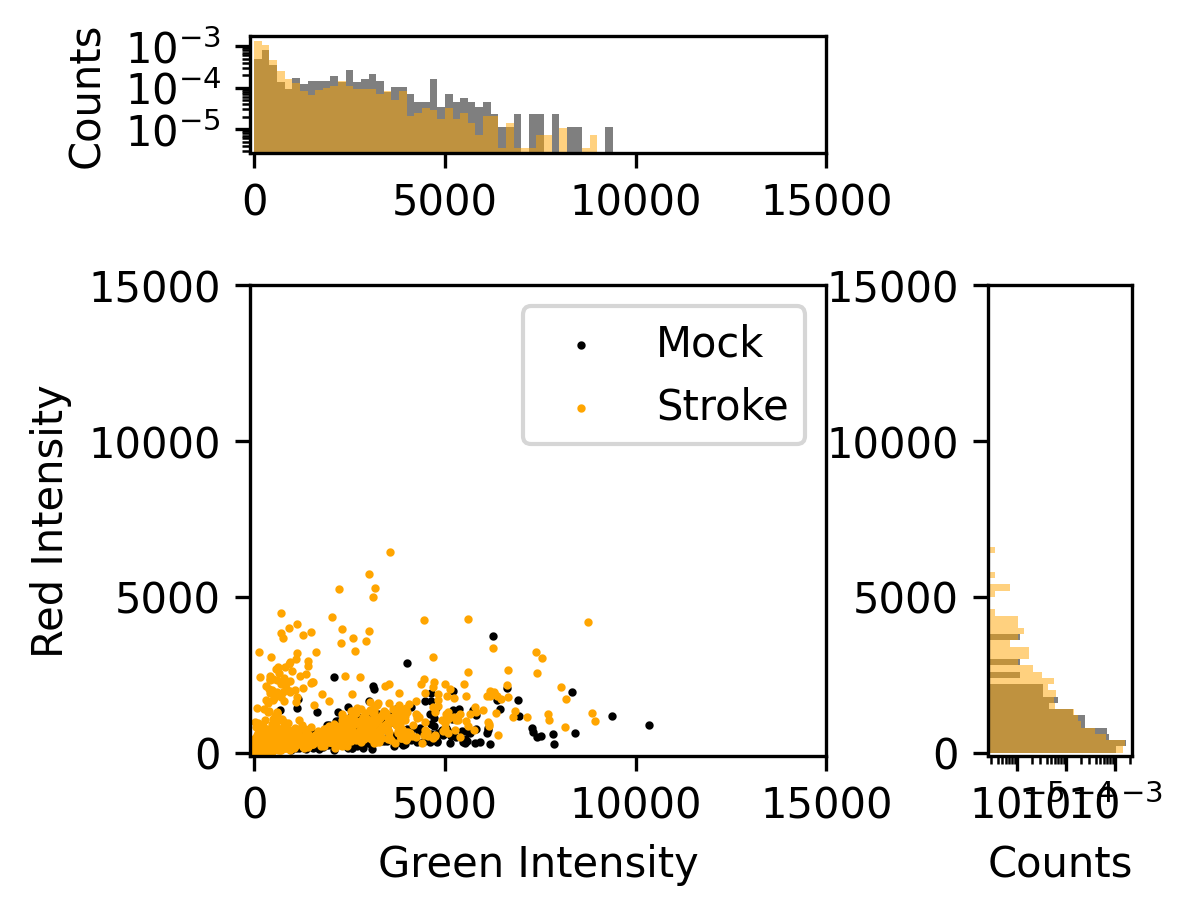

In [19]:
figure = plt.figure(figsize=(8, 8))
gs = figure.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.01, right=0.99, bottom=0.1, top=0.9,
                      wspace=0.45, hspace=0.45)
# Create the Axes.
axes = figure.add_subplot(gs[1, 0])
axes_hist_green = figure.add_subplot(gs[0, 0], sharex=axes)
axes_hist_red = figure.add_subplot(gs[1, 1], sharey=axes)
# Draw the scatter plot and marginals.

for con in conditions:

    selected_data = cell_data_output.loc[cell_data_output['stimuli']==con]
    red_intensity = selected_data['red_int']
    green_intensity = selected_data['green_int']
    positve_intensity = np.logical_and(green_intensity > 0,red_intensity>0)
    
    axes.scatter(green_intensity[positve_intensity], red_intensity[positve_intensity], color = stimuli_color[con], s = 1)
    
    x = green_intensity[positve_intensity]
    y = red_intensity[positve_intensity]
    axes_hist_green.hist(x, bins = bins, density = True, color = stimuli_color[con],alpha = 0.5)
    axes_hist_red.hist(y, bins = bins, density = True, color = stimuli_color[con],alpha = 0.5, orientation='horizontal')
 
axes.set_xlim([-100,15000])
axes.set_ylim([-100,15000])
axes.set_xlabel('Green Intensity')
axes.set_ylabel('Red Intensity')
axes.legend(stimuli_names)


#axes_hist_green.legend(stimuli_names)
axes_hist_green.set_yscale('log')
axes_hist_red.set_xscale('log')
axes_hist_green.set_ylabel('Counts')
axes_hist_red.set_xlabel('Counts')

figure.set_size_inches([3,3])
plt.tight_layout()

figure.savefig(directory_path + 'figures/' + 'converted_vs_mock_intensity_scatter.png')

In [ ]:
#import matplotlib.colors as mcolors
#plt.hist2d(x,y,bins=20, norm=mcolors.PowerNorm(0.1), cmap = 'gray')

In [ ]:
cell_data_output = pd.read_excel(data_base_path_output)
conditions = np.unique(cell_data_output['stimuli'])
print(conditions)
import numpy as np
from sklearn.linear_model import LinearRegression

In [ ]:
x = np.arange(0,10000)
for con in conditions:

    selected_data = cell_data_output.loc[cell_data_output['stimuli']==con]
    red_intensity = selected_data['red_int']
    green_intensity = selected_data['green_int']
    positve_intensity = np.logical_and(green_intensity > 0,red_intensity>0)
    
    X = green_intensity[positve_intensity]
    y = red_intensity[positve_intensity]
    reg = LinearRegression().fit(X, y)
    y_pred = reg.coef_[0] * x + reg.intercept_


In [ ]:
np.where(masks==16)

15